In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [34]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [35]:
date = "20190828"
run_name = "08_28_2019_run_01"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [7]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [8]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [9]:
from pore_utils import smith_waterman as s_w

In [10]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [11]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [12]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[13:21:53 - __main__] Getting molbit sequences.
[13:21:53 - __main__] Locating fastq files.
[13:21:53 - __main__] Running SW, one fastq at a time.
[13:21:53 - __main__] Starting fastq (0 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_0_0.fastq


[########################################] | 100% Completed | 38.0s


[13:22:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_0_0.tsv
[13:22:32 - __main__] Starting fastq (1 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_0_1.fastq


[########################################] | 100% Completed | 55.0s


[13:23:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_0_1.tsv
[13:23:27 - __main__] Starting fastq (2 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_0_2.fastq


[########################################] | 100% Completed | 30.3s


[13:23:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_0_2.tsv
[13:23:57 - __main__] Starting fastq (3 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_0_3.fastq


[########################################] | 100% Completed | 13.2s


[13:24:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_0_3.tsv
[13:24:11 - __main__] Starting fastq (4 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_1_0.fastq


[########################################] | 100% Completed |  1min 37.1s


[13:25:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_1_0.tsv
[13:25:49 - __main__] Starting fastq (5 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_1_1.fastq


[########################################] | 100% Completed | 18.8s


[13:26:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_1_1.tsv
[13:26:08 - __main__] Starting fastq (6 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_1_2.fastq


[########################################] | 100% Completed | 18.1s


[13:26:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_1_2.tsv
[13:26:26 - __main__] Starting fastq (7 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_2_0.fastq


[########################################] | 100% Completed | 41.4s


[13:27:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_2_0.tsv
[13:27:08 - __main__] Starting fastq (8 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_2_1.fastq


[########################################] | 100% Completed |  1min 20.3s


[13:28:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_2_1.tsv
[13:28:29 - __main__] Starting fastq (9 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_1_3.fastq


[########################################] | 100% Completed |  3.5s


[13:28:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_1_3.tsv
[13:28:32 - __main__] Starting fastq (10 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_2_2.fastq


[########################################] | 100% Completed | 11.4s


[13:28:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_2_2.tsv
[13:28:44 - __main__] Starting fastq (11 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_3_0.fastq


[########################################] | 100% Completed | 59.1s


[13:29:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_3_0.tsv
[13:29:44 - __main__] Starting fastq (12 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_3_1.fastq


[########################################] | 100% Completed | 42.0s


[13:30:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_3_1.tsv
[13:30:26 - __main__] Starting fastq (13 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_2_3.fastq


[########################################] | 100% Completed | 12.5s


[13:30:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_2_3.tsv
[13:30:39 - __main__] Starting fastq (14 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_3_2.fastq


[########################################] | 100% Completed | 42.5s


[13:31:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_3_2.tsv
[13:31:22 - __main__] Starting fastq (15 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_3_3.fastq


[########################################] | 100% Completed |  1.0s


[13:31:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_3_3.tsv
[13:31:23 - __main__] Starting fastq (16 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_4_0.fastq


[########################################] | 100% Completed | 49.0s


[13:32:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_4_0.tsv
[13:32:12 - __main__] Starting fastq (17 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_4_1.fastq


[########################################] | 100% Completed | 52.2s


[13:33:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_4_1.tsv
[13:33:05 - __main__] Starting fastq (18 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_4_2.fastq


[########################################] | 100% Completed | 12.6s


[13:33:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_4_2.tsv
[13:33:18 - __main__] Starting fastq (19 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_4_3.fastq


[########################################] | 100% Completed | 28.5s


[13:33:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_4_3.tsv
[13:33:46 - __main__] Starting fastq (20 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_5_0.fastq


[########################################] | 100% Completed | 40.2s


[13:34:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_5_0.tsv
[13:34:27 - __main__] Starting fastq (21 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_5_1.fastq


[########################################] | 100% Completed | 29.4s


[13:34:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_5_1.tsv
[13:34:57 - __main__] Starting fastq (22 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_5_2.fastq


[########################################] | 100% Completed |  1min 13.5s


[13:36:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_5_2.tsv
[13:36:11 - __main__] Starting fastq (23 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_5_3.fastq


[########################################] | 100% Completed |  1.7s


[13:36:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_5_3.tsv
[13:36:13 - __main__] Starting fastq (24 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_6_0.fastq


[########################################] | 100% Completed |  1min  9.7s


[13:37:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_6_0.tsv
[13:37:23 - __main__] Starting fastq (25 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_6_1.fastq


[########################################] | 100% Completed | 33.9s


[13:37:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_6_1.tsv
[13:37:57 - __main__] Starting fastq (26 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_6_2.fastq


[########################################] | 100% Completed | 38.3s


[13:38:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_6_2.tsv
[13:38:36 - __main__] Starting fastq (27 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_7_0.fastq


[########################################] | 100% Completed |  1min 45.0s


[13:40:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_7_0.tsv
[13:40:21 - __main__] Starting fastq (28 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_7_1.fastq


[########################################] | 100% Completed | 22.0s


[13:40:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_7_1.tsv
[13:40:44 - __main__] Starting fastq (29 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_6_3.fastq


[########################################] | 100% Completed |  1.3s


[13:40:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_6_3.tsv
[13:40:45 - __main__] Starting fastq (30 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_7_2.fastq


[########################################] | 100% Completed |  3.6s


[13:40:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_7_2.tsv
[13:40:49 - __main__] Starting fastq (31 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_7_3.fastq


[########################################] | 100% Completed |  9.5s


[13:40:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_7_3.tsv
[13:40:59 - __main__] Starting fastq (32 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_8_0.fastq


[########################################] | 100% Completed | 45.2s


[13:41:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_8_0.tsv
[13:41:44 - __main__] Starting fastq (33 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_8_1.fastq


[########################################] | 100% Completed |  1min  6.1s


[13:42:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_8_1.tsv
[13:42:51 - __main__] Starting fastq (34 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_8_2.fastq


[########################################] | 100% Completed | 28.0s


[13:43:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_8_2.tsv
[13:43:19 - __main__] Starting fastq (35 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_9_0.fastq


[########################################] | 100% Completed |  1min 14.1s


[13:44:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_9_0.tsv
[13:44:34 - __main__] Starting fastq (36 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_9_1.fastq


[########################################] | 100% Completed | 39.1s


[13:45:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_9_1.tsv
[13:45:13 - __main__] Starting fastq (37 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_9_2.fastq


[########################################] | 100% Completed | 29.8s


[13:45:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_9_2.tsv
[13:45:43 - __main__] Starting fastq (38 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_10_0.fastq


[########################################] | 100% Completed |  1min  1.7s


[13:46:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_10_0.tsv
[13:46:46 - __main__] Starting fastq (39 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_10_1.fastq


[########################################] | 100% Completed | 49.1s


[13:47:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_10_1.tsv
[13:47:35 - __main__] Starting fastq (40 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_10_2.fastq


[########################################] | 100% Completed | 30.9s


[13:48:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_10_2.tsv
[13:48:06 - __main__] Starting fastq (41 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_8_3.fastq


[########################################] | 100% Completed |  3.9s


[13:48:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_8_3.tsv
[13:48:10 - __main__] Starting fastq (42 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_9_3.fastq


[########################################] | 100% Completed |  0.9s


[13:48:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_9_3.tsv
[13:48:12 - __main__] Starting fastq (43 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_10_3.fastq


[########################################] | 100% Completed |  1.7s


[13:48:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_10_3.tsv
[13:48:14 - __main__] Starting fastq (44 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_11_0.fastq


[########################################] | 100% Completed | 37.2s


[13:48:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_11_0.tsv
[13:48:51 - __main__] Starting fastq (45 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_11_1.fastq


[########################################] | 100% Completed |  1min  1.0s


[13:49:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_11_1.tsv
[13:49:53 - __main__] Starting fastq (46 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_11_2.fastq


[########################################] | 100% Completed | 21.8s


[13:50:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_11_2.tsv
[13:50:15 - __main__] Starting fastq (47 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_11_3.fastq


[########################################] | 100% Completed | 23.9s


[13:50:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_11_3.tsv
[13:50:39 - __main__] Starting fastq (48 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_12_0.fastq


[########################################] | 100% Completed | 25.8s


[13:51:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_12_0.tsv
[13:51:05 - __main__] Starting fastq (49 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_12_1.fastq


[########################################] | 100% Completed | 53.0s


[13:51:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_12_1.tsv
[13:51:58 - __main__] Starting fastq (50 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_12_2.fastq


[########################################] | 100% Completed | 50.9s


[13:52:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_12_2.tsv
[13:52:50 - __main__] Starting fastq (51 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_12_3.fastq


[########################################] | 100% Completed | 13.4s


[13:53:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_12_3.tsv
[13:53:03 - __main__] Starting fastq (52 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_13_0.fastq


[########################################] | 100% Completed |  1min  8.7s


[13:54:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_13_0.tsv
[13:54:13 - __main__] Starting fastq (53 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_13_1.fastq


[########################################] | 100% Completed |  8.5s


[13:54:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_13_1.tsv
[13:54:21 - __main__] Starting fastq (54 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_13_2.fastq


[########################################] | 100% Completed |  1min  1.4s


[13:55:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_13_2.tsv
[13:55:23 - __main__] Starting fastq (55 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_14_0.fastq


[########################################] | 100% Completed |  1min  9.0s


[13:56:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_14_0.tsv
[13:56:33 - __main__] Starting fastq (56 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_14_1.fastq


[########################################] | 100% Completed | 47.3s


[13:57:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_14_1.tsv
[13:57:20 - __main__] Starting fastq (57 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_13_3.fastq


[########################################] | 100% Completed |  5.8s


[13:57:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_13_3.tsv
[13:57:26 - __main__] Starting fastq (58 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_14_2.fastq


[########################################] | 100% Completed | 26.4s


[13:57:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_14_2.tsv
[13:57:53 - __main__] Starting fastq (59 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_15_0.fastq


[########################################] | 100% Completed | 13.1s


[13:58:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_15_0.tsv
[13:58:06 - __main__] Starting fastq (60 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_15_1.fastq


[########################################] | 100% Completed | 39.0s


[13:58:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_15_1.tsv
[13:58:46 - __main__] Starting fastq (61 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_14_3.fastq


[########################################] | 100% Completed |  1.0s


[13:58:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_14_3.tsv
[13:58:47 - __main__] Starting fastq (62 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_15_2.fastq


[########################################] | 100% Completed |  3.1s


[13:58:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_15_2.tsv
[13:58:50 - __main__] Starting fastq (63 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_16_0.fastq


[########################################] | 100% Completed | 33.2s


[13:59:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_16_0.tsv
[13:59:24 - __main__] Starting fastq (64 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_16_1.fastq


[########################################] | 100% Completed |  1min 32.7s


[14:00:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_16_1.tsv
[14:00:57 - __main__] Starting fastq (65 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_15_3.fastq


[########################################] | 100% Completed |  1min 29.6s


[14:02:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_15_3.tsv
[14:02:27 - __main__] Starting fastq (66 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_16_2.fastq


[########################################] | 100% Completed | 15.2s


[14:02:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_16_2.tsv
[14:02:43 - __main__] Starting fastq (67 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_17_0.fastq


[########################################] | 100% Completed |  1min  9.9s


[14:03:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_17_0.tsv
[14:03:53 - __main__] Starting fastq (68 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_17_1.fastq


[########################################] | 100% Completed | 57.9s


[14:04:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_17_1.tsv
[14:04:51 - __main__] Starting fastq (69 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_16_3.fastq


[########################################] | 100% Completed |  1.4s


[14:04:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_16_3.tsv
[14:04:53 - __main__] Starting fastq (70 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_17_2.fastq


[########################################] | 100% Completed |  9.6s


[14:05:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_17_2.tsv
[14:05:03 - __main__] Starting fastq (71 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_17_3.fastq


[########################################] | 100% Completed |  4.4s


[14:05:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_17_3.tsv
[14:05:07 - __main__] Starting fastq (72 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_18_0.fastq


[########################################] | 100% Completed | 32.7s


[14:05:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_18_0.tsv
[14:05:40 - __main__] Starting fastq (73 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_18_1.fastq


[########################################] | 100% Completed |  1min  5.3s


[14:06:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_18_1.tsv
[14:06:46 - __main__] Starting fastq (74 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_18_2.fastq


[########################################] | 100% Completed | 15.3s


[14:07:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_18_2.tsv
[14:07:02 - __main__] Starting fastq (75 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_18_3.fastq


[########################################] | 100% Completed | 30.7s


[14:07:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_18_3.tsv
[14:07:33 - __main__] Starting fastq (76 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_19_0.fastq


[########################################] | 100% Completed | 36.1s


[14:08:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_19_0.tsv
[14:08:09 - __main__] Starting fastq (77 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_19_1.fastq


[########################################] | 100% Completed | 40.0s


[14:08:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_19_1.tsv
[14:08:50 - __main__] Starting fastq (78 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_19_2.fastq


[########################################] | 100% Completed | 19.8s


[14:09:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_19_2.tsv
[14:09:10 - __main__] Starting fastq (79 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_19_3.fastq


[########################################] | 100% Completed | 46.4s


[14:09:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_19_3.tsv
[14:09:56 - __main__] Starting fastq (80 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_20_0.fastq


[########################################] | 100% Completed | 52.6s


[14:10:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_20_0.tsv
[14:10:49 - __main__] Starting fastq (81 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_20_1.fastq


[########################################] | 100% Completed | 34.1s


[14:11:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_20_1.tsv
[14:11:24 - __main__] Starting fastq (82 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_20_2.fastq


[########################################] | 100% Completed | 11.0s


[14:11:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_20_2.tsv
[14:11:35 - __main__] Starting fastq (83 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_20_3.fastq


[########################################] | 100% Completed | 45.3s


[14:12:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_20_3.tsv
[14:12:21 - __main__] Starting fastq (84 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_21_0.fastq


[########################################] | 100% Completed | 51.6s


[14:13:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_21_0.tsv
[14:13:13 - __main__] Starting fastq (85 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_21_1.fastq


[########################################] | 100% Completed |  1min 23.1s


[14:14:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_21_1.tsv
[14:14:36 - __main__] Starting fastq (86 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_21_2.fastq


[########################################] | 100% Completed | 10.4s


[14:14:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_21_2.tsv
[14:14:47 - __main__] Starting fastq (87 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_22_0.fastq


[########################################] | 100% Completed |  1min 16.1s


[14:16:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_22_0.tsv
[14:16:03 - __main__] Starting fastq (88 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_21_3.fastq


[########################################] | 100% Completed |  0.9s


[14:16:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_21_3.tsv
[14:16:05 - __main__] Starting fastq (89 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_22_1.fastq


[########################################] | 100% Completed | 28.0s


[14:16:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_22_1.tsv
[14:16:33 - __main__] Starting fastq (90 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_22_2.fastq


[########################################] | 100% Completed |  2.6s


[14:16:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_22_2.tsv
[14:16:36 - __main__] Starting fastq (91 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_23_0.fastq


[########################################] | 100% Completed |  1min  0.2s


[14:17:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_23_0.tsv
[14:17:36 - __main__] Starting fastq (92 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_23_1.fastq


[########################################] | 100% Completed |  1min 16.8s


[14:18:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_23_1.tsv
[14:18:54 - __main__] Starting fastq (93 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_22_3.fastq


[########################################] | 100% Completed | 37.2s


[14:19:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_22_3.tsv
[14:19:31 - __main__] Starting fastq (94 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_23_2.fastq


[########################################] | 100% Completed |  5.4s


[14:19:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_23_2.tsv
[14:19:37 - __main__] Starting fastq (95 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_23_3.fastq


[########################################] | 100% Completed |  1.7s


[14:19:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_23_3.tsv
[14:19:39 - __main__] Starting fastq (96 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_24_0.fastq


[########################################] | 100% Completed | 40.6s


[14:20:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_24_0.tsv
[14:20:20 - __main__] Starting fastq (97 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_24_1.fastq


[########################################] | 100% Completed | 18.3s


[14:20:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_24_1.tsv
[14:20:38 - __main__] Starting fastq (98 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_24_2.fastq


[########################################] | 100% Completed |  1min  8.1s


[14:21:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_24_2.tsv
[14:21:47 - __main__] Starting fastq (99 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_25_0.fastq


[########################################] | 100% Completed | 36.4s


[14:22:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_25_0.tsv
[14:22:24 - __main__] Starting fastq (100 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_24_3.fastq


[########################################] | 100% Completed | 17.2s


[14:22:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_24_3.tsv
[14:22:41 - __main__] Starting fastq (101 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_25_1.fastq


[########################################] | 100% Completed |  1min 15.3s


[14:23:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_25_1.tsv
[14:23:57 - __main__] Starting fastq (102 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_26_0.fastq


[########################################] | 100% Completed | 21.0s


[14:24:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_26_0.tsv
[14:24:18 - __main__] Starting fastq (103 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_25_2.fastq


[########################################] | 100% Completed |  1.0s


[14:24:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_25_2.tsv
[14:24:19 - __main__] Starting fastq (104 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_26_1.fastq


[########################################] | 100% Completed | 36.9s


[14:24:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_26_1.tsv
[14:24:57 - __main__] Starting fastq (105 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_27_0.fastq


[########################################] | 100% Completed | 45.3s


[14:25:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_27_0.tsv
[14:25:42 - __main__] Starting fastq (106 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_27_1.fastq


[########################################] | 100% Completed |  1min 37.5s


[14:27:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_27_1.tsv
[14:27:21 - __main__] Starting fastq (107 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_26_2.fastq


[########################################] | 100% Completed |  1min 23.2s


[14:28:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_26_2.tsv
[14:28:44 - __main__] Starting fastq (108 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_25_3.fastq


[########################################] | 100% Completed | 30.4s


[14:29:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_25_3.tsv
[14:29:15 - __main__] Starting fastq (109 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_26_3.fastq


[########################################] | 100% Completed |  1.0s


[14:29:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_26_3.tsv
[14:29:16 - __main__] Starting fastq (110 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_27_2.fastq


[########################################] | 100% Completed |  1.7s


[14:29:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_27_2.tsv
[14:29:18 - __main__] Starting fastq (111 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_28_0.fastq


[########################################] | 100% Completed | 47.5s


[14:30:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_28_0.tsv
[14:30:06 - __main__] Starting fastq (112 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_28_1.fastq


[########################################] | 100% Completed |  1min 27.0s


[14:31:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_28_1.tsv
[14:31:34 - __main__] Starting fastq (113 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_28_2.fastq


[########################################] | 100% Completed |  6.0s


[14:31:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_28_2.tsv
[14:31:40 - __main__] Starting fastq (114 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_29_0.fastq


[########################################] | 100% Completed | 12.9s


[14:31:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_29_0.tsv
[14:31:53 - __main__] Starting fastq (115 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_29_1.fastq


[########################################] | 100% Completed |  1min  2.2s


[14:32:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_29_1.tsv
[14:32:56 - __main__] Starting fastq (116 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_27_3.fastq


[########################################] | 100% Completed |  1.2s


[14:32:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_27_3.tsv
[14:32:57 - __main__] Starting fastq (117 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_28_3.fastq


[########################################] | 100% Completed |  0.9s


[14:32:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_28_3.tsv
[14:32:58 - __main__] Starting fastq (118 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_29_2.fastq


[########################################] | 100% Completed |  1min  2.5s


[14:34:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_29_2.tsv
[14:34:01 - __main__] Starting fastq (119 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_30_0.fastq


[########################################] | 100% Completed |  1min 33.9s


[14:35:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_30_0.tsv
[14:35:36 - __main__] Starting fastq (120 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_29_3.fastq


[########################################] | 100% Completed |  1.0s


[14:35:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_29_3.tsv
[14:35:37 - __main__] Starting fastq (121 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_30_1.fastq


[########################################] | 100% Completed |  0.9s


[14:35:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_30_1.tsv
[14:35:38 - __main__] Starting fastq (122 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_31_0.fastq


[########################################] | 100% Completed |  1min 56.1s


[14:37:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_31_0.tsv
[14:37:35 - __main__] Starting fastq (123 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_30_2.fastq


[########################################] | 100% Completed |  2.8s


[14:37:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_30_2.tsv
[14:37:38 - __main__] Starting fastq (124 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_31_1.fastq


[########################################] | 100% Completed | 11.5s


[14:37:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_31_1.tsv
[14:37:50 - __main__] Starting fastq (125 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_32_0.fastq


[########################################] | 100% Completed |  2min  6.2s


[14:39:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_32_0.tsv
[14:39:56 - __main__] Starting fastq (126 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_30_3.fastq


[########################################] | 100% Completed | 44.7s


[14:40:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_30_3.tsv
[14:40:41 - __main__] Starting fastq (127 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_31_2.fastq


[########################################] | 100% Completed | 13.8s


[14:40:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_31_2.tsv
[14:40:56 - __main__] Starting fastq (128 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_32_1.fastq


[########################################] | 100% Completed |  8.6s


[14:41:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_32_1.tsv
[14:41:04 - __main__] Starting fastq (129 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_31_3.fastq


[########################################] | 100% Completed |  1.0s


[14:41:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_31_3.tsv
[14:41:06 - __main__] Starting fastq (130 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_32_2.fastq


[########################################] | 100% Completed |  2.4s


[14:41:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_32_2.tsv
[14:41:08 - __main__] Starting fastq (131 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_32_3.fastq


[########################################] | 100% Completed |  2.2s


[14:41:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_32_3.tsv
[14:41:11 - __main__] Starting fastq (132 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_33_0.fastq


[########################################] | 100% Completed |  1min 10.0s


[14:42:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_33_0.tsv
[14:42:21 - __main__] Starting fastq (133 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_33_1.fastq


[########################################] | 100% Completed | 19.4s


[14:42:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_33_1.tsv
[14:42:41 - __main__] Starting fastq (134 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_33_2.fastq


[########################################] | 100% Completed | 48.8s


[14:43:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_33_2.tsv
[14:43:30 - __main__] Starting fastq (135 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_34_0.fastq


[########################################] | 100% Completed | 48.3s


[14:44:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_34_0.tsv
[14:44:19 - __main__] Starting fastq (136 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_33_3.fastq


[########################################] | 100% Completed |  4.2s


[14:44:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_33_3.tsv
[14:44:23 - __main__] Starting fastq (137 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_34_1.fastq


[########################################] | 100% Completed |  4.7s


[14:44:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_34_1.tsv
[14:44:28 - __main__] Starting fastq (138 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_35_0.fastq


[########################################] | 100% Completed |  2min  6.9s


[14:46:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_35_0.tsv
[14:46:36 - __main__] Starting fastq (139 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_34_2.fastq


[########################################] | 100% Completed | 43.8s


[14:47:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_34_2.tsv
[14:47:20 - __main__] Starting fastq (140 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_34_3.fastq


[########################################] | 100% Completed | 47.3s


[14:48:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_34_3.tsv
[14:48:07 - __main__] Starting fastq (141 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_35_1.fastq


[########################################] | 100% Completed |  2.5s


[14:48:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_35_1.tsv
[14:48:10 - __main__] Starting fastq (142 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_36_0.fastq


[########################################] | 100% Completed | 51.0s


[14:49:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_36_0.tsv
[14:49:02 - __main__] Starting fastq (143 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_35_2.fastq


[########################################] | 100% Completed |  3.3s


[14:49:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_35_2.tsv
[14:49:05 - __main__] Starting fastq (144 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_36_1.fastq


[########################################] | 100% Completed |  1min 28.4s


[14:50:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_36_1.tsv
[14:50:34 - __main__] Starting fastq (145 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_35_3.fastq


[########################################] | 100% Completed |  8.4s


[14:50:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_35_3.tsv
[14:50:43 - __main__] Starting fastq (146 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_36_2.fastq


[########################################] | 100% Completed |  0.9s


[14:50:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_36_2.tsv
[14:50:44 - __main__] Starting fastq (147 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_37_0.fastq


[########################################] | 100% Completed |  1min 42.2s


[14:52:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_37_0.tsv
[14:52:27 - __main__] Starting fastq (148 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_36_3.fastq


[########################################] | 100% Completed |  1.4s


[14:52:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_36_3.tsv
[14:52:28 - __main__] Starting fastq (149 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_37_1.fastq


[########################################] | 100% Completed | 28.8s


[14:52:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_37_1.tsv
[14:52:57 - __main__] Starting fastq (150 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_37_2.fastq


[########################################] | 100% Completed |  3.3s


[14:53:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_37_2.tsv
[14:53:01 - __main__] Starting fastq (151 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_38_0.fastq


[########################################] | 100% Completed | 24.4s


[14:53:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_38_0.tsv
[14:53:26 - __main__] Starting fastq (152 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_37_3.fastq


[########################################] | 100% Completed |  7.3s


[14:53:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_37_3.tsv
[14:53:33 - __main__] Starting fastq (153 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_38_1.fastq


[########################################] | 100% Completed | 11.0s


[14:53:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_38_1.tsv
[14:53:44 - __main__] Starting fastq (154 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_38_2.fastq


[########################################] | 100% Completed |  1min 24.3s


[14:55:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_38_2.tsv
[14:55:09 - __main__] Starting fastq (155 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_39_0.fastq


[########################################] | 100% Completed |  1min  0.1s


[14:56:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_39_0.tsv
[14:56:10 - __main__] Starting fastq (156 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_39_1.fastq


[########################################] | 100% Completed |  1min 18.8s


[14:57:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_39_1.tsv
[14:57:29 - __main__] Starting fastq (157 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_40_0.fastq


[########################################] | 100% Completed |  1min 33.9s


[14:59:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_40_0.tsv
[14:59:03 - __main__] Starting fastq (158 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_38_3.fastq


[########################################] | 100% Completed | 20.5s


[14:59:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_38_3.tsv
[14:59:24 - __main__] Starting fastq (159 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_39_2.fastq


[########################################] | 100% Completed |  0.9s


[14:59:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_39_2.tsv
[14:59:25 - __main__] Starting fastq (160 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_40_1.fastq


[########################################] | 100% Completed | 34.2s


[15:00:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_40_1.tsv
[15:00:00 - __main__] Starting fastq (161 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_40_2.fastq


[########################################] | 100% Completed |  0.9s


[15:00:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_40_2.tsv
[15:00:01 - __main__] Starting fastq (162 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_41_0.fastq


[########################################] | 100% Completed |  1min 12.9s


[15:01:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_41_0.tsv
[15:01:14 - __main__] Starting fastq (163 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_41_1.fastq


[########################################] | 100% Completed | 39.7s


[15:01:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_41_1.tsv
[15:01:54 - __main__] Starting fastq (164 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_39_3.fastq


[########################################] | 100% Completed |  1.0s


[15:01:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_39_3.tsv
[15:01:56 - __main__] Starting fastq (165 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_40_3.fastq


[########################################] | 100% Completed | 12.7s


[15:02:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_40_3.tsv
[15:02:09 - __main__] Starting fastq (166 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_41_2.fastq


[########################################] | 100% Completed | 21.9s


[15:02:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_41_2.tsv
[15:02:31 - __main__] Starting fastq (167 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_41_3.fastq


[########################################] | 100% Completed |  5.6s


[15:02:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_41_3.tsv
[15:02:37 - __main__] Starting fastq (168 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_42_0.fastq


[########################################] | 100% Completed | 39.9s


[15:03:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_42_0.tsv
[15:03:17 - __main__] Starting fastq (169 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_42_1.fastq


[########################################] | 100% Completed | 28.9s


[15:03:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_42_1.tsv
[15:03:46 - __main__] Starting fastq (170 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_42_2.fastq


[########################################] | 100% Completed |  1min  8.8s


[15:04:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_42_2.tsv
[15:04:56 - __main__] Starting fastq (171 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_43_0.fastq


[########################################] | 100% Completed |  1min 33.7s


[15:06:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_43_0.tsv
[15:06:30 - __main__] Starting fastq (172 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_42_3.fastq


[########################################] | 100% Completed |  1.7s


[15:06:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_42_3.tsv
[15:06:32 - __main__] Starting fastq (173 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_43_1.fastq


[########################################] | 100% Completed | 33.0s


[15:07:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_43_1.tsv
[15:07:05 - __main__] Starting fastq (174 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_43_2.fastq


[########################################] | 100% Completed | 10.3s


[15:07:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_43_2.tsv
[15:07:16 - __main__] Starting fastq (175 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_44_0.fastq


[########################################] | 100% Completed |  1min  8.4s


[15:08:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_44_0.tsv
[15:08:24 - __main__] Starting fastq (176 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_44_1.fastq


[########################################] | 100% Completed | 57.3s


[15:09:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_44_1.tsv
[15:09:22 - __main__] Starting fastq (177 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_43_3.fastq


[########################################] | 100% Completed |  1.7s


[15:09:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_43_3.tsv
[15:09:24 - __main__] Starting fastq (178 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_44_2.fastq


[########################################] | 100% Completed |  2.6s


[15:09:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_44_2.tsv
[15:09:27 - __main__] Starting fastq (179 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_45_0.fastq


[########################################] | 100% Completed |  1min 49.8s


[15:11:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_45_0.tsv
[15:11:17 - __main__] Starting fastq (180 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_45_1.fastq


[########################################] | 100% Completed | 21.2s


[15:11:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_45_1.tsv
[15:11:39 - __main__] Starting fastq (181 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_45_2.fastq


[########################################] | 100% Completed | 16.7s


[15:11:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_45_2.tsv
[15:11:56 - __main__] Starting fastq (182 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_46_0.fastq


[########################################] | 100% Completed |  1min  1.0s


[15:12:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_46_0.tsv
[15:12:57 - __main__] Starting fastq (183 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_46_1.fastq


[########################################] | 100% Completed |  1min 16.7s


[15:14:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_46_1.tsv
[15:14:14 - __main__] Starting fastq (184 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_47_0.fastq


[########################################] | 100% Completed | 52.6s


[15:15:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_47_0.tsv
[15:15:07 - __main__] Starting fastq (185 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_44_3.fastq


[########################################] | 100% Completed | 10.6s


[15:15:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_44_3.tsv
[15:15:18 - __main__] Starting fastq (186 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_45_3.fastq


[########################################] | 100% Completed |  0.9s


[15:15:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_45_3.tsv
[15:15:19 - __main__] Starting fastq (187 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_46_2.fastq


[########################################] | 100% Completed |  0.8s


[15:15:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_46_2.tsv
[15:15:20 - __main__] Starting fastq (188 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_47_1.fastq


[########################################] | 100% Completed | 58.7s


[15:16:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_47_1.tsv
[15:16:20 - __main__] Starting fastq (189 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_47_2.fastq


[########################################] | 100% Completed | 31.1s


[15:16:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_47_2.tsv
[15:16:51 - __main__] Starting fastq (190 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_48_0.fastq


[########################################] | 100% Completed | 37.4s


[15:17:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_48_0.tsv
[15:17:29 - __main__] Starting fastq (191 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_46_3.fastq


[########################################] | 100% Completed |  0.9s


[15:17:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_46_3.tsv
[15:17:30 - __main__] Starting fastq (192 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_47_3.fastq


[########################################] | 100% Completed |  0.9s


[15:17:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_47_3.tsv
[15:17:31 - __main__] Starting fastq (193 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_48_1.fastq


[########################################] | 100% Completed |  1min 27.7s


[15:18:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_48_1.tsv
[15:18:59 - __main__] Starting fastq (194 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_48_2.fastq


[########################################] | 100% Completed | 17.2s


[15:19:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_48_2.tsv
[15:19:17 - __main__] Starting fastq (195 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_48_3.fastq


[########################################] | 100% Completed |  1.0s


[15:19:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_48_3.tsv
[15:19:18 - __main__] Starting fastq (196 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_49_0.fastq


[########################################] | 100% Completed | 33.8s


[15:19:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_49_0.tsv
[15:19:52 - __main__] Starting fastq (197 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_49_1.fastq


[########################################] | 100% Completed |  1min  9.0s


[15:21:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_49_1.tsv
[15:21:02 - __main__] Starting fastq (198 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_49_2.fastq


[########################################] | 100% Completed | 33.7s


[15:21:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_49_2.tsv
[15:21:36 - __main__] Starting fastq (199 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_50_0.fastq


[########################################] | 100% Completed |  1min 20.0s


[15:22:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_50_0.tsv
[15:22:56 - __main__] Starting fastq (200 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_50_1.fastq


[########################################] | 100% Completed | 37.9s


[15:23:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_50_1.tsv
[15:23:34 - __main__] Starting fastq (201 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_50_2.fastq


[########################################] | 100% Completed | 23.9s


[15:23:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_50_2.tsv
[15:23:59 - __main__] Starting fastq (202 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_49_3.fastq


[########################################] | 100% Completed |  2.7s


[15:24:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_49_3.tsv
[15:24:02 - __main__] Starting fastq (203 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_50_3.fastq


[########################################] | 100% Completed |  0.9s


[15:24:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_50_3.tsv
[15:24:03 - __main__] Starting fastq (204 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_51_0.fastq


[########################################] | 100% Completed | 55.8s


[15:24:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_51_0.tsv
[15:24:59 - __main__] Starting fastq (205 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_51_1.fastq


[########################################] | 100% Completed | 50.0s


[15:25:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_51_1.tsv
[15:25:49 - __main__] Starting fastq (206 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_51_2.fastq


[########################################] | 100% Completed | 39.3s


[15:26:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_51_2.tsv
[15:26:29 - __main__] Starting fastq (207 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_52_0.fastq


[########################################] | 100% Completed | 43.8s


[15:27:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_52_0.tsv
[15:27:13 - __main__] Starting fastq (208 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_51_3.fastq


[########################################] | 100% Completed |  1.7s


[15:27:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_51_3.tsv
[15:27:15 - __main__] Starting fastq (209 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_52_1.fastq


[########################################] | 100% Completed | 36.8s


[15:27:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_52_1.tsv
[15:27:52 - __main__] Starting fastq (210 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_52_2.fastq


[########################################] | 100% Completed | 33.0s


[15:28:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_52_2.tsv
[15:28:26 - __main__] Starting fastq (211 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_52_3.fastq


[########################################] | 100% Completed | 34.3s


[15:29:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_52_3.tsv
[15:29:00 - __main__] Starting fastq (212 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_53_0.fastq


[########################################] | 100% Completed |  1min  8.4s


[15:30:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_53_0.tsv
[15:30:09 - __main__] Starting fastq (213 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_53_1.fastq


[########################################] | 100% Completed | 16.4s


[15:30:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_53_1.tsv
[15:30:26 - __main__] Starting fastq (214 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_53_2.fastq


[########################################] | 100% Completed | 36.5s


[15:31:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_53_2.tsv
[15:31:03 - __main__] Starting fastq (215 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_53_3.fastq


[########################################] | 100% Completed | 22.5s


[15:31:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_53_3.tsv
[15:31:26 - __main__] Starting fastq (216 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_54_0.fastq


[########################################] | 100% Completed |  1min 12.6s


[15:32:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_54_0.tsv
[15:32:39 - __main__] Starting fastq (217 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_54_1.fastq


[########################################] | 100% Completed | 38.4s


[15:33:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_54_1.tsv
[15:33:17 - __main__] Starting fastq (218 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_54_2.fastq


[########################################] | 100% Completed | 31.9s


[15:33:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_54_2.tsv
[15:33:50 - __main__] Starting fastq (219 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_54_3.fastq


[########################################] | 100% Completed |  1.0s


[15:33:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_54_3.tsv
[15:33:51 - __main__] Starting fastq (220 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_55_0.fastq


[########################################] | 100% Completed | 34.0s


[15:34:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_55_0.tsv
[15:34:25 - __main__] Starting fastq (221 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_55_1.fastq


[########################################] | 100% Completed |  1min 21.1s


[15:35:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_55_1.tsv
[15:35:47 - __main__] Starting fastq (222 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_55_2.fastq


[########################################] | 100% Completed | 31.0s


[15:36:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_55_2.tsv
[15:36:18 - __main__] Starting fastq (223 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_56_0.fastq


[########################################] | 100% Completed | 36.6s


[15:36:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_56_0.tsv
[15:36:55 - __main__] Starting fastq (224 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_55_3.fastq


[########################################] | 100% Completed |  0.9s


[15:36:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_55_3.tsv
[15:36:56 - __main__] Starting fastq (225 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_56_1.fastq


[########################################] | 100% Completed |  1min  8.0s


[15:38:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_56_1.tsv
[15:38:05 - __main__] Starting fastq (226 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_56_2.fastq


[########################################] | 100% Completed | 37.1s


[15:38:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_56_2.tsv
[15:38:42 - __main__] Starting fastq (227 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_57_0.fastq


[########################################] | 100% Completed |  1min  6.0s


[15:39:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_57_0.tsv
[15:39:49 - __main__] Starting fastq (228 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_56_3.fastq


[########################################] | 100% Completed |  9.2s


[15:39:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_56_3.tsv
[15:39:58 - __main__] Starting fastq (229 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_57_1.fastq


[########################################] | 100% Completed | 25.3s


[15:40:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_57_1.tsv
[15:40:24 - __main__] Starting fastq (230 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_57_2.fastq


[########################################] | 100% Completed | 41.9s


[15:41:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_57_2.tsv
[15:41:06 - __main__] Starting fastq (231 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_58_0.fastq


[########################################] | 100% Completed |  1min  1.7s


[15:42:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_58_0.tsv
[15:42:08 - __main__] Starting fastq (232 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_57_3.fastq


[########################################] | 100% Completed |  8.2s


[15:42:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_57_3.tsv
[15:42:17 - __main__] Starting fastq (233 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_58_1.fastq


[########################################] | 100% Completed | 32.2s


[15:42:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_58_1.tsv
[15:42:49 - __main__] Starting fastq (234 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_58_2.fastq


[########################################] | 100% Completed | 34.7s


[15:43:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_58_2.tsv
[15:43:24 - __main__] Starting fastq (235 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_58_3.fastq


[########################################] | 100% Completed | 12.8s


[15:43:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_58_3.tsv
[15:43:37 - __main__] Starting fastq (236 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_59_0.fastq


[########################################] | 100% Completed | 46.6s


[15:44:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_59_0.tsv
[15:44:24 - __main__] Starting fastq (237 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_59_1.fastq


[########################################] | 100% Completed | 29.4s


[15:44:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_59_1.tsv
[15:44:54 - __main__] Starting fastq (238 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_59_2.fastq


[########################################] | 100% Completed |  1min  4.0s


[15:45:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_59_2.tsv
[15:45:59 - __main__] Starting fastq (239 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_59_3.fastq


[########################################] | 100% Completed |  0.9s


[15:46:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_59_3.tsv
[15:46:00 - __main__] Starting fastq (240 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_60_0.fastq


[########################################] | 100% Completed | 52.5s


[15:46:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_60_0.tsv
[15:46:53 - __main__] Starting fastq (241 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_60_1.fastq


[########################################] | 100% Completed |  1min  3.3s


[15:47:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_60_1.tsv
[15:47:56 - __main__] Starting fastq (242 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_60_2.fastq


[########################################] | 100% Completed | 16.9s


[15:48:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_60_2.tsv
[15:48:14 - __main__] Starting fastq (243 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_61_0.fastq


[########################################] | 100% Completed | 59.1s


[15:49:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_61_0.tsv
[15:49:13 - __main__] Starting fastq (244 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_60_3.fastq


[########################################] | 100% Completed |  6.0s


[15:49:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_60_3.tsv
[15:49:19 - __main__] Starting fastq (245 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_61_1.fastq


[########################################] | 100% Completed | 37.2s


[15:49:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_61_1.tsv
[15:49:57 - __main__] Starting fastq (246 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_61_2.fastq


[########################################] | 100% Completed | 38.5s


[15:50:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_61_2.tsv
[15:50:36 - __main__] Starting fastq (247 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_62_0.fastq


[########################################] | 100% Completed |  1min  5.5s


[15:51:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_62_0.tsv
[15:51:42 - __main__] Starting fastq (248 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_62_1.fastq


[########################################] | 100% Completed | 26.2s


[15:52:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_62_1.tsv
[15:52:08 - __main__] Starting fastq (249 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_62_2.fastq


[########################################] | 100% Completed | 18.8s


[15:52:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_62_2.tsv
[15:52:28 - __main__] Starting fastq (250 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_61_3.fastq


[########################################] | 100% Completed |  2.6s


[15:52:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_61_3.tsv
[15:52:30 - __main__] Starting fastq (251 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_62_3.fastq


[########################################] | 100% Completed | 29.7s


[15:53:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_62_3.tsv
[15:53:00 - __main__] Starting fastq (252 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_63_0.fastq


[########################################] | 100% Completed |  1min 25.2s


[15:54:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_63_0.tsv
[15:54:26 - __main__] Starting fastq (253 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_63_1.fastq


[########################################] | 100% Completed | 32.5s


[15:54:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_63_1.tsv
[15:54:59 - __main__] Starting fastq (254 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_63_2.fastq


[########################################] | 100% Completed | 14.8s


[15:55:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_63_2.tsv
[15:55:14 - __main__] Starting fastq (255 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_64_0.fastq


[########################################] | 100% Completed | 47.7s


[15:56:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_64_0.tsv
[15:56:02 - __main__] Starting fastq (256 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_64_1.fastq


[########################################] | 100% Completed |  1min 16.8s


[15:57:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_64_1.tsv
[15:57:19 - __main__] Starting fastq (257 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_63_3.fastq


[########################################] | 100% Completed |  7.0s


[15:57:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_63_3.tsv
[15:57:27 - __main__] Starting fastq (258 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_64_2.fastq


[########################################] | 100% Completed |  1.5s


[15:57:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_64_2.tsv
[15:57:28 - __main__] Starting fastq (259 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_64_3.fastq


[########################################] | 100% Completed | 14.9s


[15:57:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_64_3.tsv
[15:57:44 - __main__] Starting fastq (260 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_65_0.fastq


[########################################] | 100% Completed | 45.6s


[15:58:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_65_0.tsv
[15:58:30 - __main__] Starting fastq (261 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_65_1.fastq


[########################################] | 100% Completed |  2.4s


[15:58:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_65_1.tsv
[15:58:32 - __main__] Starting fastq (262 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_65_2.fastq


[########################################] | 100% Completed |  1min 18.0s


[15:59:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_65_2.tsv
[15:59:51 - __main__] Starting fastq (263 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_66_0.fastq


[########################################] | 100% Completed | 16.4s


[16:00:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_66_0.tsv
[16:00:08 - __main__] Starting fastq (264 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_66_1.fastq


[########################################] | 100% Completed |  1min 40.4s


[16:01:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_66_1.tsv
[16:01:49 - __main__] Starting fastq (265 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_67_0.fastq


[########################################] | 100% Completed |  1min  8.8s


[16:02:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_67_0.tsv
[16:02:58 - __main__] Starting fastq (266 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_65_3.fastq


[########################################] | 100% Completed | 15.6s


[16:03:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_65_3.tsv
[16:03:14 - __main__] Starting fastq (267 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_66_2.fastq


[########################################] | 100% Completed |  5.8s


[16:03:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_66_2.tsv
[16:03:20 - __main__] Starting fastq (268 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_67_1.fastq


[########################################] | 100% Completed | 56.3s


[16:04:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_67_1.tsv
[16:04:17 - __main__] Starting fastq (269 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_68_0.fastq


[########################################] | 100% Completed |  1min 28.9s


[16:05:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_68_0.tsv
[16:05:46 - __main__] Starting fastq (270 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_66_3.fastq


[########################################] | 100% Completed | 18.9s


[16:06:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_66_3.tsv
[16:06:05 - __main__] Starting fastq (271 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_68_1.fastq


[########################################] | 100% Completed | 10.2s


[16:06:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_68_1.tsv
[16:06:16 - __main__] Starting fastq (272 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_67_2.fastq


[########################################] | 100% Completed |  1.0s


[16:06:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_67_2.tsv
[16:06:17 - __main__] Starting fastq (273 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_68_2.fastq


[########################################] | 100% Completed | 41.4s


[16:06:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_68_2.tsv
[16:06:59 - __main__] Starting fastq (274 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_67_3.fastq


[########################################] | 100% Completed | 18.7s


[16:07:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_67_3.tsv
[16:07:18 - __main__] Starting fastq (275 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_69_0.fastq


[########################################] | 100% Completed | 47.2s


[16:08:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_69_0.tsv
[16:08:05 - __main__] Starting fastq (276 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_68_3.fastq


[########################################] | 100% Completed |  1.0s


[16:08:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_68_3.tsv
[16:08:06 - __main__] Starting fastq (277 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_69_1.fastq


[########################################] | 100% Completed |  1min 11.7s


[16:09:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_69_1.tsv
[16:09:19 - __main__] Starting fastq (278 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_69_2.fastq


[########################################] | 100% Completed |  1.0s


[16:09:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_69_2.tsv
[16:09:20 - __main__] Starting fastq (279 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_70_0.fastq


[########################################] | 100% Completed | 59.6s


[16:10:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_70_0.tsv
[16:10:20 - __main__] Starting fastq (280 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_69_3.fastq


[########################################] | 100% Completed | 19.3s


[16:10:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_69_3.tsv
[16:10:39 - __main__] Starting fastq (281 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_70_1.fastq


[########################################] | 100% Completed | 34.1s


[16:11:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_70_1.tsv
[16:11:14 - __main__] Starting fastq (282 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_70_2.fastq


[########################################] | 100% Completed |  4.8s


[16:11:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_70_2.tsv
[16:11:19 - __main__] Starting fastq (283 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_70_3.fastq


[########################################] | 100% Completed | 39.8s


[16:11:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_70_3.tsv
[16:11:59 - __main__] Starting fastq (284 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_71_0.fastq


[########################################] | 100% Completed | 38.0s


[16:12:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_71_0.tsv
[16:12:37 - __main__] Starting fastq (285 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_71_1.fastq


[########################################] | 100% Completed | 17.3s


[16:12:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_71_1.tsv
[16:12:55 - __main__] Starting fastq (286 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_71_2.fastq


[########################################] | 100% Completed |  5.1s


[16:13:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_71_2.tsv
[16:13:00 - __main__] Starting fastq (287 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_72_0.fastq


[########################################] | 100% Completed | 58.1s


[16:13:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_72_0.tsv
[16:13:59 - __main__] Starting fastq (288 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_71_3.fastq


[########################################] | 100% Completed |  1min 19.3s


[16:15:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_71_3.tsv
[16:15:19 - __main__] Starting fastq (289 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_72_1.fastq


[########################################] | 100% Completed | 52.4s


[16:16:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_72_1.tsv
[16:16:11 - __main__] Starting fastq (290 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_72_2.fastq


[########################################] | 100% Completed | 19.5s


[16:16:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_72_2.tsv
[16:16:31 - __main__] Starting fastq (291 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_73_0.fastq


[########################################] | 100% Completed |  1min 11.4s


[16:17:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_73_0.tsv
[16:17:43 - __main__] Starting fastq (292 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_73_1.fastq


[########################################] | 100% Completed |  1.0s


[16:17:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_73_1.tsv
[16:17:44 - __main__] Starting fastq (293 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_74_0.fastq


[########################################] | 100% Completed |  1min  2.7s


[16:18:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_74_0.tsv
[16:18:48 - __main__] Starting fastq (294 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_73_2.fastq


[########################################] | 100% Completed |  1min  4.8s


[16:19:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_73_2.tsv
[16:19:53 - __main__] Starting fastq (295 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_72_3.fastq


[########################################] | 100% Completed | 10.5s


[16:20:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_72_3.tsv
[16:20:04 - __main__] Starting fastq (296 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_73_3.fastq


[########################################] | 100% Completed |  1.7s


[16:20:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_73_3.tsv
[16:20:06 - __main__] Starting fastq (297 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_74_1.fastq


[########################################] | 100% Completed | 34.5s


[16:20:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_74_1.tsv
[16:20:40 - __main__] Starting fastq (298 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_74_2.fastq


[########################################] | 100% Completed |  1.7s


[16:20:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_74_2.tsv
[16:20:42 - __main__] Starting fastq (299 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_75_0.fastq


[########################################] | 100% Completed |  1min 19.0s


[16:22:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_75_0.tsv
[16:22:02 - __main__] Starting fastq (300 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_75_1.fastq


[########################################] | 100% Completed | 31.1s


[16:22:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_75_1.tsv
[16:22:33 - __main__] Starting fastq (301 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_75_2.fastq


[########################################] | 100% Completed | 22.4s


[16:22:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_75_2.tsv
[16:22:56 - __main__] Starting fastq (302 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_74_3.fastq


[########################################] | 100% Completed | 39.1s


[16:23:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_74_3.tsv
[16:23:35 - __main__] Starting fastq (303 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_76_0.fastq


[########################################] | 100% Completed | 44.9s


[16:24:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_76_0.tsv
[16:24:21 - __main__] Starting fastq (304 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_75_3.fastq


[########################################] | 100% Completed |  6.8s


[16:24:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_75_3.tsv
[16:24:28 - __main__] Starting fastq (305 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_76_1.fastq


[########################################] | 100% Completed |  1min  0.5s


[16:25:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_76_1.tsv
[16:25:29 - __main__] Starting fastq (306 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_76_2.fastq


[########################################] | 100% Completed | 17.8s


[16:25:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_76_2.tsv
[16:25:47 - __main__] Starting fastq (307 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_76_3.fastq


[########################################] | 100% Completed | 13.5s


[16:26:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_76_3.tsv
[16:26:01 - __main__] Starting fastq (308 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_77_0.fastq


[########################################] | 100% Completed | 33.7s


[16:26:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_77_0.tsv
[16:26:35 - __main__] Starting fastq (309 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_77_1.fastq


[########################################] | 100% Completed |  1min 21.3s


[16:27:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_77_1.tsv
[16:27:56 - __main__] Starting fastq (310 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_77_2.fastq


[########################################] | 100% Completed | 26.0s


[16:28:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_77_2.tsv
[16:28:23 - __main__] Starting fastq (311 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_78_0.fastq


[########################################] | 100% Completed | 58.2s


[16:29:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_78_0.tsv
[16:29:21 - __main__] Starting fastq (312 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_78_1.fastq


[########################################] | 100% Completed | 32.8s


[16:29:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_78_1.tsv
[16:29:54 - __main__] Starting fastq (313 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_77_3.fastq


[########################################] | 100% Completed |  1.0s


[16:29:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_77_3.tsv
[16:29:56 - __main__] Starting fastq (314 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_78_2.fastq


[########################################] | 100% Completed | 24.7s


[16:30:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_78_2.tsv
[16:30:21 - __main__] Starting fastq (315 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_79_0.fastq


[########################################] | 100% Completed | 39.9s


[16:31:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_79_0.tsv
[16:31:01 - __main__] Starting fastq (316 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_79_1.fastq


[########################################] | 100% Completed |  1min  0.1s


[16:32:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_79_1.tsv
[16:32:02 - __main__] Starting fastq (317 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_79_2.fastq


[########################################] | 100% Completed | 38.5s


[16:32:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_79_2.tsv
[16:32:40 - __main__] Starting fastq (318 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_78_3.fastq


[########################################] | 100% Completed | 28.4s


[16:33:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_78_3.tsv
[16:33:09 - __main__] Starting fastq (319 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_80_0.fastq


[########################################] | 100% Completed |  1min 20.7s


[16:34:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_80_0.tsv
[16:34:30 - __main__] Starting fastq (320 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_79_3.fastq


[########################################] | 100% Completed |  0.8s


[16:34:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_79_3.tsv
[16:34:31 - __main__] Starting fastq (321 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_80_1.fastq


[########################################] | 100% Completed |  1.7s


[16:34:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_80_1.tsv
[16:34:33 - __main__] Starting fastq (322 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_81_0.fastq


[########################################] | 100% Completed | 51.4s


[16:35:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_81_0.tsv
[16:35:25 - __main__] Starting fastq (323 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_80_2.fastq


[########################################] | 100% Completed | 28.7s


[16:35:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_80_2.tsv
[16:35:54 - __main__] Starting fastq (324 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_81_1.fastq


[########################################] | 100% Completed |  1min  8.7s


[16:37:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_81_1.tsv
[16:37:04 - __main__] Starting fastq (325 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_80_3.fastq


[########################################] | 100% Completed | 30.3s


[16:37:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_80_3.tsv
[16:37:34 - __main__] Starting fastq (326 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_82_0.fastq


[########################################] | 100% Completed |  1min  0.1s


[16:38:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_82_0.tsv
[16:38:35 - __main__] Starting fastq (327 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_81_2.fastq


[########################################] | 100% Completed |  7.2s


[16:38:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_81_2.tsv
[16:38:42 - __main__] Starting fastq (328 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_82_1.fastq


[########################################] | 100% Completed | 48.8s


[16:39:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_82_1.tsv
[16:39:31 - __main__] Starting fastq (329 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_81_3.fastq


[########################################] | 100% Completed | 12.7s


[16:39:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_81_3.tsv
[16:39:44 - __main__] Starting fastq (330 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_82_2.fastq


[########################################] | 100% Completed | 14.8s


[16:39:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_82_2.tsv
[16:39:59 - __main__] Starting fastq (331 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_83_0.fastq


[########################################] | 100% Completed | 35.2s


[16:40:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_83_0.tsv
[16:40:35 - __main__] Starting fastq (332 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_82_3.fastq


[########################################] | 100% Completed | 15.6s


[16:40:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_82_3.tsv
[16:40:51 - __main__] Starting fastq (333 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_83_1.fastq


[########################################] | 100% Completed |  4.5s


[16:40:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_83_1.tsv
[16:40:56 - __main__] Starting fastq (334 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_84_0.fastq


[########################################] | 100% Completed | 16.3s


[16:41:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_84_0.tsv
[16:41:12 - __main__] Starting fastq (335 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_84_1.fastq


[########################################] | 100% Completed |  1min 17.4s


[16:42:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_84_1.tsv
[16:42:30 - __main__] Starting fastq (336 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_84_2.fastq


[########################################] | 100% Completed | 32.6s


[16:43:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_84_2.tsv
[16:43:03 - __main__] Starting fastq (337 of 338)
	/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/pass/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_84_3.fastq


[########################################] | 100% Completed | 17.8s


[16:43:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/fastq_runid_852c07bf042182e22f60c3d9425876746c4da9d8_84_3.tsv


In [13]:
sw_list = []
for fname in os.listdir(sw_dir):
    if "all" in fname:
        continue
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [14]:
sw_arr = np.array(sw)

In [15]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

[16:43:27 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=19.8.
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[16:43:27 - matplotlib.fo

[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Medium.otf) normal normal medium normal>) = 10.145
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Bol

[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal regular normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Lohit Oriya' (Lohit-

[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN57F.ttf) normal normal 400 condensed>) = 10.25
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Light.otf) normal normal light normal>) = 10.24
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS76F.ttf) italic normal bold normal>) = 11.335
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS56F.ttf) italic normal 400 normal>) = 11.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-Italic.ttf) italic normal 400 normal>) = 11.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-BoldOblique.otf) oblique nor

[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.335
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Light.otf) normal normal light normal>) = 10.24
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.335
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.05
[16:43:27 - matplotlib.font_manager] findfont: score(<Font 'NanumGothic' (NanumGothicExtraBold.ttf) normal normal bold normal>) = 10.335
[16:43:27 - matplotlib.font_manager] 

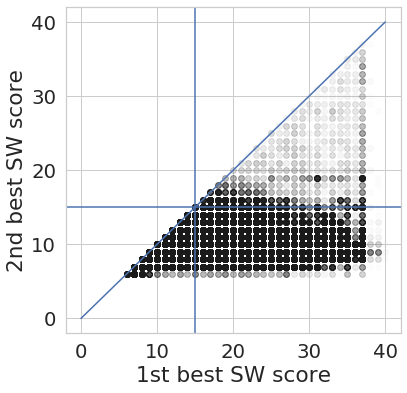

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

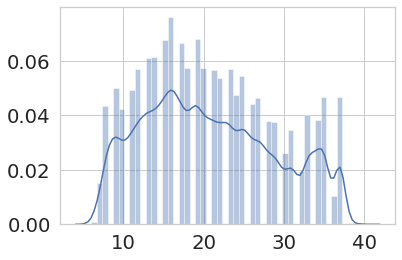

In [17]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [18]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [19]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [20]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [21]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/all_852c07bf042182e22f60c3d9425876746c4da9d8.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [36]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.split(", ")

In [37]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)

## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [24]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [25]:
len(accept_molbit)

302460

In [26]:
sum(accept_molbit)

224318

In [27]:
sum(accept_molbit) / len(accept_molbit)

0.7416451762216492

## Extract the best-aligned molbit, across ONLY the extant molbits

In [40]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [41]:
extant_sw = sw.loc[:, extant_sw_cols]

In [42]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [43]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [44]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [45]:
n_extant_is_best

223140

Percentage of well-aligned reads that belong to the true set

In [46]:
n_extant_is_best/len(sw_accepted)

0.9947485266452091

Read counts for each molbit

In [47]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('0', 4417),
 ('1', 1753),
 ('16', 9236),
 ('17', 3501),
 ('18', 3149),
 ('19', 12175),
 ('2', 6551),
 ('20', 7047),
 ('21', 4093),
 ('22', 2448),
 ('23', 853),
 ('3', 8122),
 ('32', 4901),
 ('33', 3705),
 ('34', 2076),
 ('35', 2104),
 ('36', 11386),
 ('37', 3748),
 ('38', 853),
 ('39', 2994),
 ('4', 1722),
 ('48', 6166),
 ('49', 1971),
 ('5', 4894),
 ('50', 5758),
 ('51', 16054),
 ('52', 2061),
 ('53', 1663),
 ('54', 6722),
 ('55', 2762),
 ('6', 10301),
 ('64', 225),
 ('65', 3144),
 ('66', 8131),
 ('67', 3780),
 ('68', 4667),
 ('69', 2193),
 ('7', 5504),
 ('70', 1569),
 ('71', 3060),
 ('80', 4685),
 ('81', 7748),
 ('82', 3074),
 ('83', 1906),
 ('84', 2574),
 ('85', 6727),
 ('86', 6430),
 ('87', 3715)]

In [48]:
print("\n".join([str(x) for x in c]))

4417
1753
9236
3501
3149
12175
6551
7047
4093
2448
853
8122
4901
3705
2076
2104
11386
3748
853
2994
1722
6166
1971
4894
5758
16054
2061
1663
6722
2762
10301
225
3144
8131
3780
4667
2193
5504
1569
3060
4685
7748
3074
1906
2574
6727
6430
3715


## Extract the best-aligned molbit, across ONLY the current run's molbits

In [49]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [50]:
extant_sw = sw.loc[:, extant_sw_cols]

In [51]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [52]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [53]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [54]:
n_extant_is_best

223140

Percentage of well-aligned reads that belong to the true set

In [55]:
n_extant_is_best/len(sw_accepted)

0.9947485266452091

Read counts for each molbit

In [56]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('0', 4417),
 ('1', 1753),
 ('16', 9236),
 ('17', 3501),
 ('18', 3149),
 ('19', 12175),
 ('2', 6551),
 ('20', 7047),
 ('21', 4093),
 ('22', 2448),
 ('23', 853),
 ('3', 8122),
 ('32', 4901),
 ('33', 3705),
 ('34', 2076),
 ('35', 2104),
 ('36', 11386),
 ('37', 3748),
 ('38', 853),
 ('39', 2994),
 ('4', 1722),
 ('48', 6166),
 ('49', 1971),
 ('5', 4894),
 ('50', 5758),
 ('51', 16054),
 ('52', 2061),
 ('53', 1663),
 ('54', 6722),
 ('55', 2762),
 ('6', 10301),
 ('64', 225),
 ('65', 3144),
 ('66', 8131),
 ('67', 3780),
 ('68', 4667),
 ('69', 2193),
 ('7', 5504),
 ('70', 1569),
 ('71', 3060),
 ('80', 4685),
 ('81', 7748),
 ('82', 3074),
 ('83', 1906),
 ('84', 2574),
 ('85', 6727),
 ('86', 6430),
 ('87', 3715)]

In [57]:
l = []
for i in range(0, 96, 16):
    l.extend(range(i, i+8))

In [58]:
", ".join([str(x) for x in l])

'0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49, 50, 51, 52, 53, 54, 55, 64, 65, 66, 67, 68, 69, 70, 71, 80, 81, 82, 83, 84, 85, 86, 87'

## Get counts for all molbits

In [63]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

4417
1752
6534
8122
1722
4883
10301
5497
9
6
2
4
0
24
2
19
9231
3452
3149
12174
7034
4093
2448
849
0
0
0
3
0
1
1
0
4901
3705
2075
2098
10560
3747
853
2993
1
0
0
51
0
0
4
9
6164
1871
5754
16049
2060
1661
6721
2759
13
0
2
0
0
12
42
0
225
3143
8130
3778
4658
2167
1567
3060
5
1
0
338
2
0
0
13
4640
7748
3069
1906
2573
6719
6430
3698
1
0
0
608
1
1
3
0


# Plot read counts

In [76]:
def plot_read_counts(labels, counts, labels_on_flowcell, labels_in_run,
                     possible_labels=None, ax=None, vmax=None, title_note=None):
    from matplotlib.patches import Patch
    if vmax is None:
        vmax = max(counts) + max(counts)
    if ax == None:
        fig, ax = plt.subplots(figsize=(30, 8))
    if possible_labels is None:
        possible_labels = labels[:]
    g = sns.barplot(x=labels, y=counts, order=possible_labels, ax=ax)
    title = "#/reads identified per barcode"
    if title_note is not None:
        title += "\n(%s)" % title_note
    ax.set_title(title)
    ax.set_xlabel("Barcode ID")
    ax.set_ylabel("Read counts")
    ax.set_ylim([0, vmax])
    
    prev_text_height = 0
    for j, label in enumerate(possible_labels):
        if label in labels:
            count = counts[labels.index(label)]
        else:
            count = 0
        if label == "-1":
            continue

#         try:
#             label = int(label)
#         except:
#             pass
        
        if label in labels_in_run:
            g.containers[0].get_children()[j].set_facecolor("tab:red")
            font_kwargs = {"color": "tab:red", "weight": "bold"} 
        elif label in labels_on_flowcell:
            g.containers[0].get_children()[j].set_facecolor("tab:blue")
            font_kwargs = {"color": "k", "weight": "bold"}
        else:
            g.containers[0].get_children()[j].set_facecolor("k")
            font_kwargs = {"color": "k", "weight": "normal"}
            
        diff = prev_text_height - (count + 0.01 * vmax)
        if count < 100:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif diff < 0 and np.abs(diff) < vmax * .06:
            text_height = np.max([prev_text_height + .035 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif np.abs(diff) < vmax * .05:
            text_height = np.min([prev_text_height - .01 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        else:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        prev_text_height = text_height
        
    legend_elements = [Patch(facecolor='k', edgecolor='k',
                         label='never been run on this flowcell'),
                       Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='prev run on flowcell'),
                       Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='current run on flowcell')]
    leg = ax.legend(handles=legend_elements)
    t1, t2, t3 = leg.get_texts()
    t2._fontproperties = t1._fontproperties.copy()
    t3._fontproperties = t1._fontproperties.copy()
    t2.set_weight('bold')
    t3.set_weight('bold')
    t3.set_color("tab:red")
    return ax

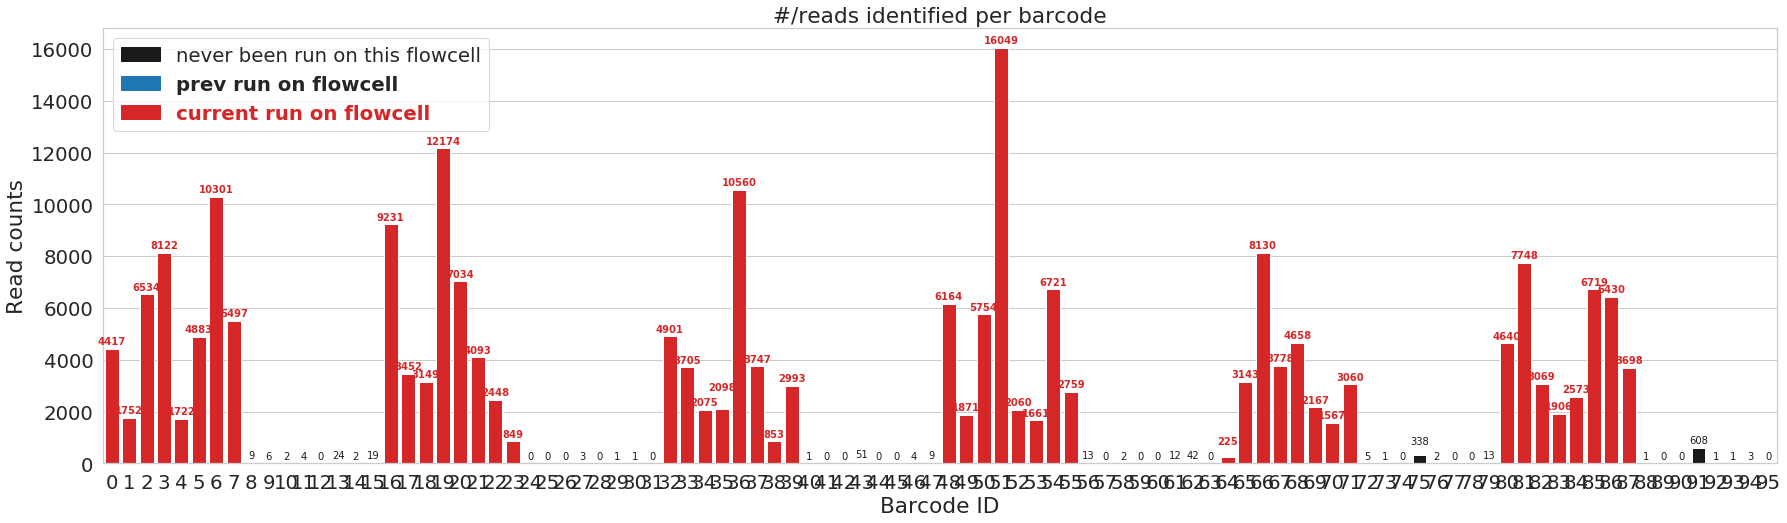

In [77]:
molbits = [str(x) for x in m]
counts = list(c)
on_flowcell = [str(x) for x in molbits_on_flowcell]
in_run = [str(x) for x in molbits_in_run]
poss_molbits = [str(x) for x in range(96)]
plot_read_counts(molbits, counts, on_flowcell, in_run, possible_labels=poss_molbits, vmax=16800)

# Save labels

In [78]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/all_852c07bf042182e22f60c3d9425876746c4da9d8.tsv'

In [83]:
sw = pd.read_csv(merged_sw_file, sep="\t", index_col=0)
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit
sw["best_molbit_is_in_run"] = sw["best_molbit"].apply(lambda x: x in molbits_in_run)

labels_in_set = sw[np.logical_and(sw["accept_molbit"], sw["best_molbit_is_in_run"])]

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


In [82]:
sw_label_file = merged_sw_file.replace("all", "labels_for_molbits_in_set")
print(sw_label_file)

/path/to/data/MinION_sequencing_data_20190828/guppy_3.2.2_08_28_2019_run_01_exec_20190828/sw/labels_for_molbits_in_set_852c07bf042182e22f60c3d9425876746c4da9d8.tsv


In [84]:
best_score = np.max(labels_in_set[[f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]], axis=1)
labels_in_set["best_score"] = best_score
labels_in_set = labels_in_set.loc[:, ["best_molbit", "best_score"]]
labels_in_set.columns = ["molbit", "sw_score"]

labels_in_set.to_csv(sw_label_file, sep="\t", index=True)

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
